# Sensitivities and Specificities

### Imports

In [35]:
import numpy as np
import gmpy2
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import colorcet as cc
from matplotlib.colors import LinearSegmentedColormap
gmpy2.get_context().precision = 113

# Setting the color palette for the plots
sns.set_theme(style='whitegrid', palette="pastel")

cmap = "Oranges"

### Importing Quickscore

In [2]:
import importlib
from quickscore import fun_quickscoreW2_gmpy2

### Importing Metric Function

In [3]:
import metrics
importlib.reload(metrics)
from metrics import compute_metrics

## Fixed Values

In [4]:
# For reproducibility
np.random.seed(42) 

# Parameters

# Number of diseases
n_disease = 30

# Number of tests
n_test = 50

# Typical number of diagnoses, should be smaller than n_deases/2
expected_number_of_diseases = 4

# Every disease has an equal prior 
prev = np.full(n_disease, expected_number_of_diseases/n_disease)

## Compute Specificities

In [5]:
def compute_specificity(prev, sensorig, connections=None):
    # if no connection matrix, then use 'full' (just to compare in simulations)
    if(connections is None):
        connections = np.ones_like(sensorig)
        
    specificity = np.zeros_like(sensorig, dtype=float)
    n_test, n_disease = sensorig.shape
    for j in range(n_test):
        specificity_init = np.prod( (1-sensorig[j,:])*prev + (1-prev))
        for i in range(n_disease):
            specificity[j,i] = specificity_init / ((1-sensorig[j,i])*prev[i] + (1-prev[i]))
        
    return specificity*connections

## 1. Periodic Connections and Fixed Sensitivities

### Generating a periodic connections matrix

In [6]:
def generate_periodic_connections(n, connection_width):
    
    if not (1 <= connection_width <= n):
        raise ValueError("connection_width must be between 1 and n.")
    
    connections = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(connection_width):
            col = (i + j) % n
            connections[i, col] = 1

    return connections

In [7]:
# Scaling down

# Number of diseases
n_disease = 10

# Number of tests, should be the same as number of diseases for periodic connections matrix
n_test = n_disease
expected_number_of_diseases = 1

# Number of trials
n_trials = 20

# Every disease has an equal prior 
prev = np.full(n_disease, expected_number_of_diseases/n_disease)

In [8]:

all_connection_widths = np.arange(n_test)+1 # from 1 to n_test (inclusive)
all_sensitivities = np.linspace(0.1, 1, 10)

i_trials = len(all_connection_widths)
j_trials = len(all_sensitivities)

# Sensitivities and specificities across trials
noz_sensitivities  = np.empty((i_trials, j_trials))
noz_specificities  = np.empty((i_trials, j_trials))

npos_diag_per_trial = np.empty(n_trials)
npos_test_per_trial = np.empty(n_trials)

# Metrics per trial
loss_per_trial = np.empty(n_trials)
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials)
f1_score_per_trial = np.empty(n_trials)

# Averaged metrics across all trials
mean_loss = np.empty((i_trials, j_trials))
mean_precision = np.empty((i_trials, j_trials))
mean_recall = np.empty((i_trials, j_trials))
mean_f1 = np.empty((i_trials, j_trials))

for i, connection_width in enumerate(all_connection_widths):
    print(i)
    
    for j, sensitivity in enumerate(all_sensitivities):
        
        connections = generate_periodic_connections(n_test, connection_width)
        sensorig = np.full((n_test, n_disease), sensitivity, dtype=np.float32) * connections
        
        specificity = compute_specificity(prev, sensorig, connections) 
        
        noz_sens_tmp = sensorig[connections != 0]
        noz_sensitivities[i,j] = np.mean(noz_sens_tmp)
        
        noz_spec_tmp = specificity[connections != 0]
        noz_specificities[i,j] = np.mean(noz_spec_tmp)

        for n in range(n_trials):
            flag = 1
            while flag:
                state_vector = np.random.random(len(prev)) < prev
                actualdiags = np.nonzero(state_vector)[0].tolist()

                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)
                if m>0:
                    flag = 0  # Exit loop if conditions met. "With one positive test you go to the doctor. Otherwise no reason to diagnose."
                    #print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")

                    
            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]                 
            sensneg = sensorig[negtest, :]              
            pfmin = 1 - sens                          
            pfminneg = np.prod(1 - sensneg, axis=0)     

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1
            
            npos_diag_per_trial[n] = ndiags
            npos_test_per_trial[n] = m
            
            
            # Metric Calculation
            metrics = compute_metrics(actualdiseases, posteriorg) # compute metrics is a function I implemented, computes

            loss_per_trial[n] = metrics["log_loss"]
            precision_per_trial[n] = metrics["precision"]
            f1_score_per_trial[n] = metrics["f1_score"]
            recall_per_trial[n] = metrics["recall"]
            
        # Collect statistics of metrics per parameter setting  
        mean_loss[i,j] = np.mean(loss_per_trial)
        mean_precision[i,j] = np.mean(precision_per_trial)
        mean_recall[i,j] = np.mean(recall_per_trial)
        mean_f1[i,j] = np.mean(f1_score_per_trial)

        

0
1
2
3
4
5
6
7
8
9


### Plotting the relationship between sensitivities, connection width and specificities

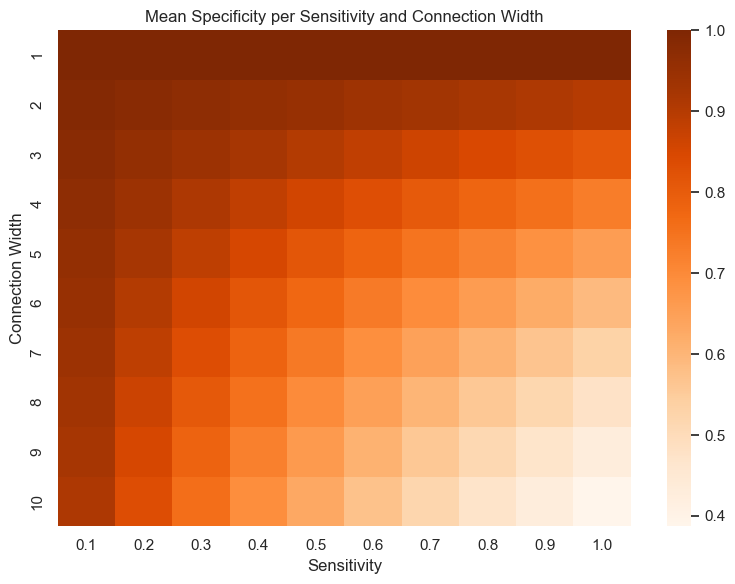

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(noz_specificities, 
            xticklabels=np.round(all_sensitivities, 2), 
            yticklabels=all_connection_widths,
            cmap=cmap)

plt.xlabel("Sensitivity")
plt.ylabel("Connection Width")
plt.title("Mean Specificity per Sensitivity and Connection Width")
plt.tight_layout()
plt.savefig("sp3-A.pdf", dpi=300, bbox_inches='tight')

### Sensitivities and Connection Width vs Network Performance

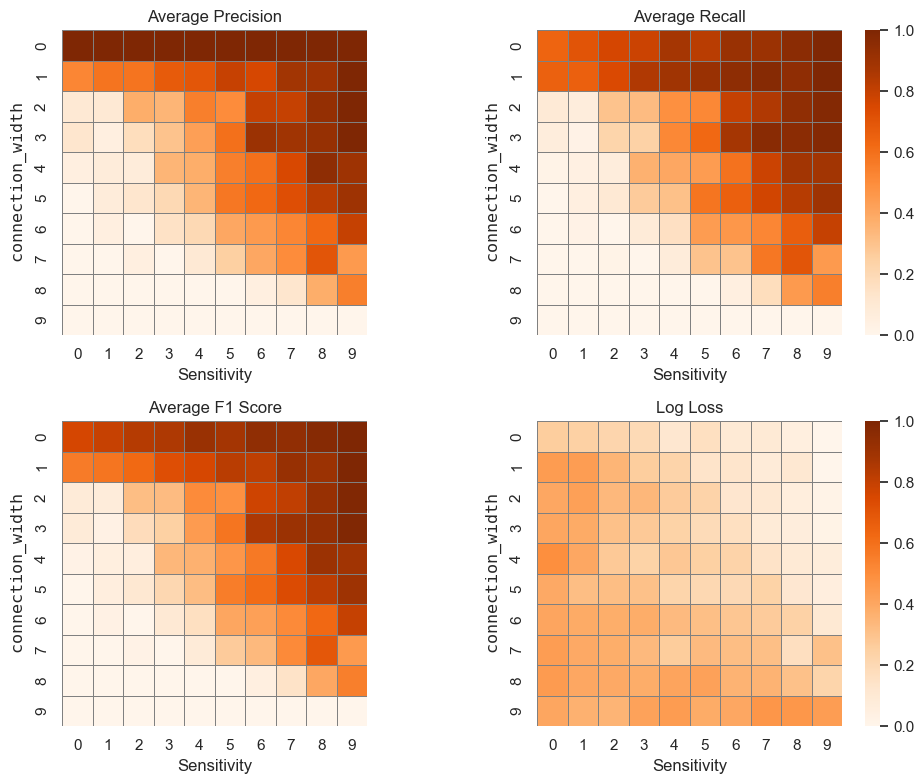

In [10]:
matrices = dict()
titles = dict()
matrices[0,0] = mean_precision
matrices[0,1] = mean_recall
matrices[1,0] = mean_f1
matrices[1,1] = mean_loss 
titles[0,0] = 'Average Precision'
titles[0,1] = 'Average Recall'
titles[1,0] = 'Average F1 Score'
titles[1,1] = 'Log Loss'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))


for row in range(2):
    for col in range(2):
       
        ax = axes[row, col]
        
        sns.heatmap(matrices[row,col], ax=ax, vmin=0, vmax=1, square=True, cmap=cmap,
                    linewidths=0.5, linecolor='gray', cbar=True if col==1 else False)
        
        ax.set_title(titles[row,col])
        
        ax.set_xlabel("Sensitivity")
        ax.set_ylabel(r"$\mathtt{connection\_width}$")

  
plt.tight_layout()
plt.savefig("sp3-B.pdf", dpi=300, bbox_inches='tight')

### Sensitivities and Specificities vs Algorithm Performance

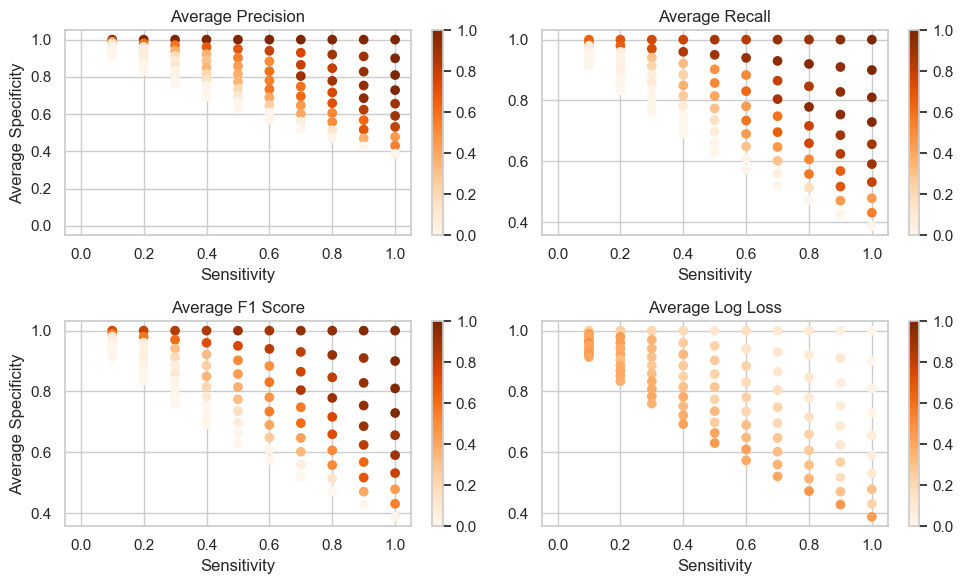

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes = axes.flatten()
# Set up limits and labels for consistency
xlim = (-0.05, 1.05)
ylim = (-0.05, 1.05)

vmin = 0
vmax = 1

# Flatten input arrays if needed
x = noz_sensitivities.ravel()
y = noz_specificities.ravel()

# Precision
sc0 = axes[0].scatter(x, y, c=mean_precision.ravel(), vmin=vmin, vmax=vmax, cmap=cmap )
axes[0].set_title('Average Precision')
axes[0].set_xlabel('Sensitivity')
axes[0].set_ylabel('Average Specificity')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].grid(True)
cbar0 = fig.colorbar(sc0, ax=axes[0])


# Recall
sc1 = axes[1].scatter(x, y, c=mean_recall.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[1].set_title('Average Recall')
axes[1].set_xlabel('Sensitivity')
axes[1].set_xlim(xlim)
axes[1].grid(True)
cbar1 = fig.colorbar(sc1, ax=axes[1])


# F1 Score
sc2 = axes[2].scatter(x, y, c=mean_f1.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[2].set_title('Average F1 Score')
axes[2].set_xlabel('Sensitivity')
axes[2].set_ylabel('Average Specificity')
axes[2].set_xlim(xlim)
axes[2].grid(True)
cbar2 = fig.colorbar(sc2, ax=axes[2])


# Log Loss
sc3 = axes[3].scatter(x, y, c=mean_loss.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[3].set_title('Average Log Loss')
axes[3].set_xlabel('Sensitivity')
axes[3].set_xlim(xlim)
axes[3].grid(True)
cbar3 = fig.colorbar(sc3, ax=axes[3])

plt.tight_layout()
plt.savefig("sp3-C.pdf", dpi=300, bbox_inches='tight')

### Sum/Product of sensitivities and specificities vs Algorithm Performance

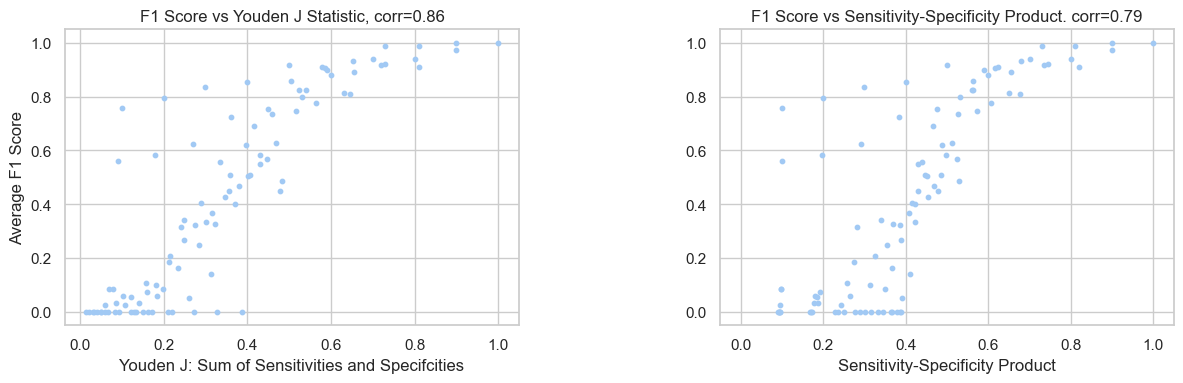

In [12]:
# correlations with f1
noz_sum = noz_sensitivities + noz_specificities - 1 
noz_prod = noz_sensitivities * noz_specificities

cornozsumf1 =np.corrcoef(noz_sum.ravel(),mean_f1.ravel())[0,1]
cornozprodf1 = np.corrcoef(noz_prod.ravel(),mean_f1.ravel())[0,1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# first row: f1 vs full
ax = axes[0]
ax.scatter(noz_sum,mean_f1,s=10)
ax.set_ylabel('Average F1 Score')
ax.set_title(f'F1 Score vs Youden J Statistic, corr={cornozsumf1:.2f}')
ax.set_xlabel('Youden J: Sum of Sensitivities and Specifcities')
#ax.set_xlim(-1.05, 1.05)

ax = axes[1]
ax.scatter(noz_prod,mean_f1,s=10)
ax.set_title(f'F1 Score vs Sensitivity-Specificity Product. corr={cornozprodf1:.2f}')
ax.set_xlabel('Sensitivity-Specificity Product')
ax.set_xlim(-0.05, 1.05)

plt.tight_layout(w_pad=10.0)
plt.savefig("sp3-D.pdf", dpi=300, bbox_inches='tight')

## 2. Random Structure and Beta Distribution of Sensitivities

In [13]:
# Number of diseases
n_disease = 20

# Number of tests
n_test = 10

# Typical number of diagnoses
expected_number_of_diseases = 3

# Every disease has an equal prior 
prev = np.full(n_disease, expected_number_of_diseases/n_disease)
# Number of trials
n_trials = 20

In [14]:
all_sparsenesses = np.linspace(0.1, 1, 10)
all_sensitivities = np.linspace(0.1, 1, 10)

i_trials = len(all_sparsenesses)
j_trials = len(all_sensitivities)

noz_sensitivities  = np.empty((i_trials, j_trials))
noz_specificities  = np.empty((i_trials, j_trials))

# Metrics per trial
loss_per_trial = np.empty(n_trials)
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials)
f1_score_per_trial = np.empty(n_trials)

# Averaged metrics across trials
mean_loss = np.empty((i_trials, j_trials))
mean_precision = np.empty((i_trials, j_trials))
mean_recall = np.empty((i_trials, j_trials))
mean_f1 = np.empty((i_trials, j_trials))

for i, sparseness in enumerate(all_sparsenesses):
    print(i) 
    
    for j, sensitivity in enumerate(all_sensitivities):
        connections = (np.random.rand(n_test, n_disease) < sparseness)*1
        sensorig = np.random.beta(a=sensitivity*10+0.1, b=(1-sensitivity)*10+0.1, size=connections.shape)* connections
        
        specificity = compute_specificity(prev, sensorig, connections) 
        noz_sens_tmp = sensorig[connections != 0]
        noz_sensitivities[i,j] = np.mean(noz_sens_tmp)
        
        noz_spec_tmp = specificity[connections != 0]
        noz_specificities[i,j] = np.mean(noz_spec_tmp)

        for n in range(n_trials):
            flag = 1
            while flag:
                state_vector = np.random.random(len(prev)) < prev
                actualdiags = np.nonzero(state_vector)[0].tolist()

                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)
                if m>0:
                    flag = 0  # Exit loop if conditions met. "With one positive test you go to the doctor. Otherwise no reason to diagnose."
                    #print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")

                    
            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]                 
            sensneg = sensorig[negtest, :]              
            pfmin = 1 - sens                          
            pfminneg = np.prod(1 - sensneg, axis=0)     

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1
            
            
            # Metric Calculation
            metrics = compute_metrics(actualdiseases, posteriorg) # compute metrics is a function I implemented, computes

            loss_per_trial[n] = metrics["log_loss"]
            precision_per_trial[n] = metrics["precision"]
            f1_score_per_trial[n] = metrics["f1_score"]
            recall_per_trial[n] = metrics["recall"]
            
        # Collect statistics of metrics per parameter setting  
        mean_loss[i,j] = np.mean(loss_per_trial)
        mean_precision[i,j] = np.mean(precision_per_trial)
        mean_recall[i,j] = np.mean(recall_per_trial)
        mean_f1[i,j] = np.mean(f1_score_per_trial)
    

0
1
2
3
4
5
6
7
8
9


### Sensitivities and Specificities vs Algorithm Performance

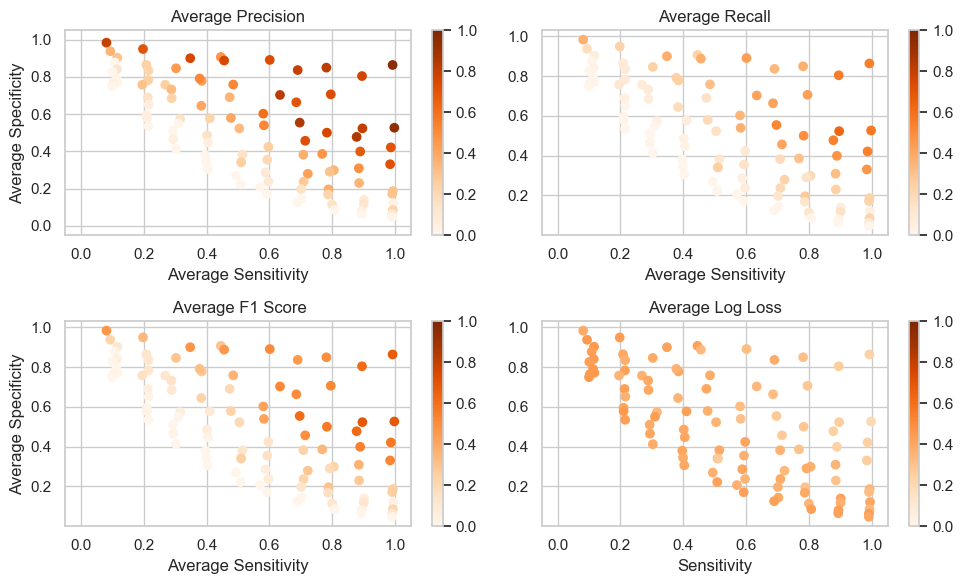

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes = axes.flatten()
# Set up limits and labels for consistency
xlim = (-0.05, 1.05)
ylim = (-0.05, 1.05)

vmin = 0
vmax = 1

# Flatten input arrays if needed
x = noz_sensitivities.ravel()
y = noz_specificities.ravel()

# Precision
sc0 = axes[0].scatter(x, y, c=mean_precision.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Average Precision')
axes[0].set_xlabel('Average Sensitivity')
axes[0].set_ylabel('Average Specificity')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].grid(True)
cbar0 = fig.colorbar(sc0, ax=axes[0])


# Recall
sc1 = axes[1].scatter(x, y, c=mean_recall.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[1].set_title('Average Recall')
axes[1].set_xlabel('Average Sensitivity')
axes[1].set_xlim(xlim)
axes[1].grid(True)
cbar1 = fig.colorbar(sc1, ax=axes[1])


# F1 Score
sc2 = axes[2].scatter(x, y, c=mean_f1.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[2].set_title(' Average F1 Score')
axes[2].set_xlabel('Average Sensitivity')
axes[2].set_ylabel('Average Specificity')
axes[2].set_xlim(xlim)
axes[2].grid(True)
cbar2 = fig.colorbar(sc2, ax=axes[2])


# Log Loss
sc3 = axes[3].scatter(x, y, c=mean_loss.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[3].set_title('Average Log Loss')
axes[3].set_xlabel('Sensitivity')
axes[3].set_xlim(xlim)
axes[3].grid(True)
cbar3 = fig.colorbar(sc3, ax=axes[3])

plt.tight_layout()
plt.savefig("sp3-E.pdf", dpi=300, bbox_inches='tight')

### Sum/Product of sensitivities and specificities vs Algorithm Performance

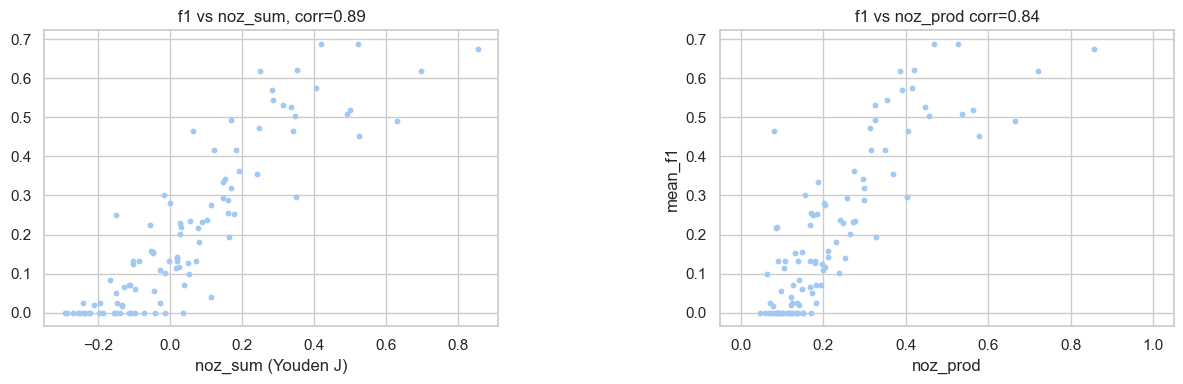

In [16]:
# correlations with f1
noz_sum = noz_sensitivities + noz_specificities - 1
noz_prod = noz_sensitivities * noz_specificities

cornozsumf1 =np.corrcoef(noz_sum.ravel(),mean_f1.ravel())[0,1]
cornozprodf1 = np.corrcoef(noz_prod.ravel(),mean_f1.ravel())[0,1]

# make pscatter plots

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# first row: f1 vs full
ax = axes[0]
ax.scatter(noz_sum,mean_f1,s=10)
ax.set_title(f'f1 vs noz_sum, corr={cornozsumf1:.2f}')
ax.set_xlabel('noz_sum (Youden J)')
#ax.set_xlim(-1.05, 1.05)

ax = axes[1]
ax.scatter(noz_prod,mean_f1,s=10)
ax.set_title(f'f1 vs noz_prod corr={cornozprodf1:.2f}')
ax.set_xlabel('noz_prod')
ax.set_ylabel('mean_f1')
ax.set_xlim(-0.05, 1.05)

plt.tight_layout(w_pad=10.0)

## Preferential Structure and Beta Distribution of Sensitivities

### Generate Preferential Attachment Structure

In [17]:
def generate_pref_att_structure(n_test, n_disease, n_common_test, p_common = 0.7, p_noncon = 0.2):

    connections = np.zeros((n_test,n_disease), dtype=bool)

    # Choose some findings to be the ones that are connected to a lot of diseases - parameter n_common_test
    common_test = np.random.choice(n_test, n_common_test, replace=False)

    # Assigning more connections to common findings
    for t in range(n_test):
        if t in common_test:
            connections[t,:] = np.random.rand(n_disease) < p_common
        else:
            connections[t,:] = np.random.rand(n_disease) < p_noncon

    return connections

In [18]:
# Number of diseases
n_disease = 20

# Number of tests: for this experiment need not be the same as n_disease
n_test = 10

# Typical number of diagnoses, should be smaller than n_deases/2
expected_number_of_diseases = 3

# Every disease has an equal prior 
prev = np.full(n_disease, expected_number_of_diseases/n_disease)*2*np.random.rand(n_disease)

# Number of trials
n_trials = 20

In [19]:
all_sensitivities = np.linspace(0.1, 1, 10)
all_common_tests = np.arange(0, n_test+1)

i_trials = len(all_common_tests)
j_trials = len(all_sensitivities)

noz_sensitivities  = np.empty((i_trials, j_trials))
noz_specificities  = np.empty((i_trials, j_trials))

# Metrics per trial
loss_per_trial = np.empty(n_trials)
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials)
f1_score_per_trial = np.empty(n_trials)

# Averaged metrics across trials
mean_loss = np.empty((i_trials, j_trials))
mean_precision = np.empty((i_trials, j_trials))
mean_recall = np.empty((i_trials, j_trials))
mean_f1 = np.empty((i_trials, j_trials))

for i, n_common in enumerate(all_common_tests):
    
    print(i) 
    for j, sensitivity in enumerate(all_sensitivities):
        connections = generate_pref_att_structure(n_test, n_disease, n_common)
        
        #sensorig = np.full((n_test, n_disease), sensitivity, dtype=np.float32) * connections
        sensorig = np.random.beta(a=sensitivity*10+0.1, b=(1-sensitivity)*10+0.1, size=connections.shape)* connections
        
        specificity = compute_specificity(prev, sensorig, connections) 
        noz_sens_tmp = sensorig[connections != 0]
        noz_sensitivities[i,j] = np.mean(noz_sens_tmp)
        
        noz_spec_tmp = specificity[connections != 0]
        noz_specificities[i,j] = np.mean(noz_spec_tmp)

        # now given the network, we do some trials
        for n in range(n_trials):
            flag = 1
            while flag:
                state_vector = np.random.random(len(prev)) < prev
                actualdiags = np.nonzero(state_vector)[0].tolist()

                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)
                if m>0:
                    flag = 0  # Exit loop if conditions met. "With one positive test you go to the doctor. Otherwise no reason to diagnose."
                    #print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")

                    
            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]                 
            sensneg = sensorig[negtest, :]              
            pfmin = 1 - sens                          
            pfminneg = np.prod(1 - sensneg, axis=0)     

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1
            
            npos_diag_per_trial[n] = ndiags
            npos_test_per_trial[n] = m
            
            
            # Metric Calculation
            metrics = compute_metrics(actualdiseases, posteriorg) # compute metrics is a function I implemented, computes

            loss_per_trial[n] = metrics["log_loss"]
            precision_per_trial[n] = metrics["precision"]
            f1_score_per_trial[n] = metrics["f1_score"]
            recall_per_trial[n] = metrics["recall"]
            
        # Collect statistics of metrics per parameter setting  
        mean_loss[i,j] = np.mean(loss_per_trial)
        mean_precision[i,j] = np.mean(precision_per_trial)
        mean_recall[i,j] = np.mean(recall_per_trial)
        mean_f1[i,j] = np.mean(f1_score_per_trial)

0
1
2
3
4
5
6
7
8
9
10


### Sensitivities and Specificities vs Algorithm Performance

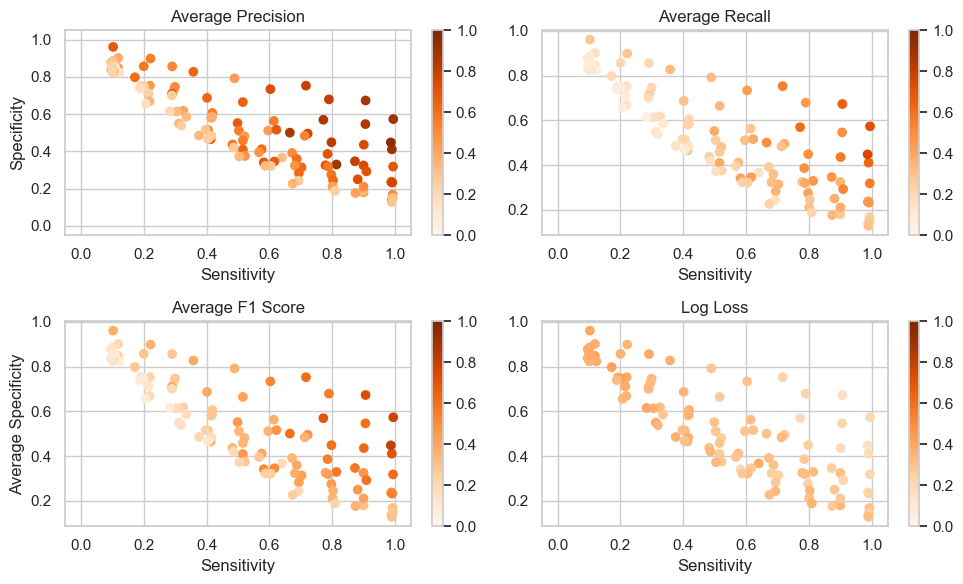

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes = axes.flatten()
# Set up limits and labels for consistency
xlim = (-0.05, 1.05)
ylim = (-0.05, 1.05)

vmin = 0
vmax = 1

# Flatten input arrays if needed
x = noz_sensitivities.ravel()
y = noz_specificities.ravel()

# Plot 1: Precision
sc0 = axes[0].scatter(x, y, c=mean_precision.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title('Average Precision')
axes[0].set_xlabel('Sensitivity')
axes[0].set_ylabel('Specificity')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].grid(True)
cbar0 = fig.colorbar(sc0, ax=axes[0])


# Plot 2: Recall
sc1 = axes[1].scatter(x, y, c=mean_recall.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[1].set_title('Average Recall')
axes[1].set_xlabel('Sensitivity')
axes[1].set_xlim(xlim)
axes[1].grid(True)
cbar1 = fig.colorbar(sc1, ax=axes[1])


# Plot 3: F1 Score
sc2 = axes[2].scatter(x, y, c=mean_f1.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[2].set_title('Average F1 Score')
axes[2].set_xlabel('Sensitivity')
axes[2].set_ylabel('Average Specificity')
axes[2].set_xlim(xlim)
axes[2].grid(True)
cbar2 = fig.colorbar(sc2, ax=axes[2])


# Plot 4: 1 - Log Loss
sc3 = axes[3].scatter(x, y, c = mean_loss.ravel(), vmin=vmin, vmax=vmax, cmap=cmap)
axes[3].set_title('Log Loss')
axes[3].set_xlabel('Sensitivity')
axes[3].set_xlim(xlim)
axes[3].grid(True)
cbar3 = fig.colorbar(sc3, ax=axes[3])

plt.tight_layout()
plt.savefig("sp3-F.pdf", dpi=300, bbox_inches='tight')

### Sum/Product of sensitivities and specificities vs Algorithm Performance

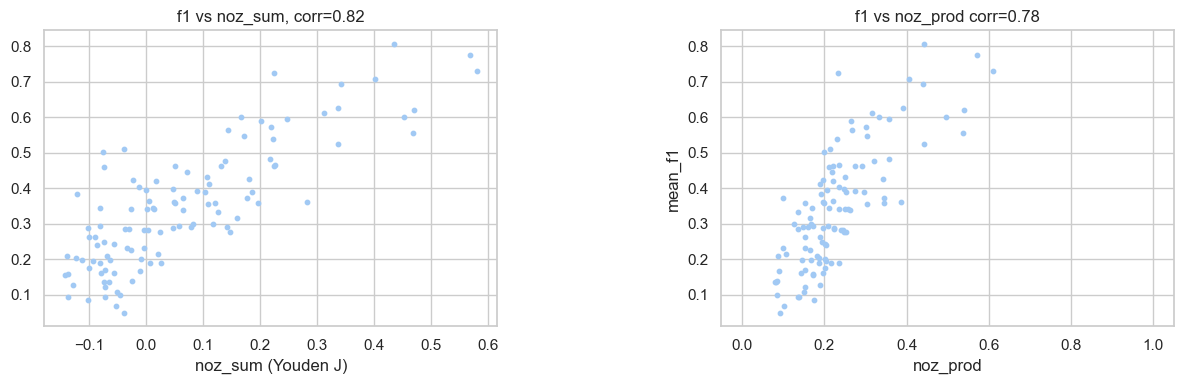

In [21]:
# correlations with f1
noz_sum = noz_sensitivities + noz_specificities - 1 # See Wikipedia: Youden's J statistics
noz_prod = noz_sensitivities * noz_specificities

cornozsumf1 =np.corrcoef(noz_sum.ravel(),mean_f1.ravel())[0,1]
cornozprodf1 = np.corrcoef(noz_prod.ravel(),mean_f1.ravel())[0,1]

# make pscatter plots

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# first row: f1 vs full
ax = axes[0]
ax.scatter(noz_sum,mean_f1,s=10)
ax.set_title(f'f1 vs noz_sum, corr={cornozsumf1:.2f}')
ax.set_xlabel('noz_sum (Youden J)')
#ax.set_xlim(-1.05, 1.05)

ax = axes[1]
ax.scatter(noz_prod,mean_f1,s=10)
ax.set_title(f'f1 vs noz_prod corr={cornozprodf1:.2f}')
ax.set_xlabel('noz_prod')
ax.set_ylabel('mean_f1')
ax.set_xlim(-0.05, 1.05)

plt.tight_layout(w_pad=10.0)

# Prevalences vs Sensitivities and Specificities

In [38]:
n_disease = 10

# Number of tests: for this experiment need not be the same as n_disease
n_test = 10

# Typical number of diagnoses, should be smaller than n_deases/2
expected_number_of_diseases = 2


# Connections matrix
sparseness = 0.3
connections = (np.random.rand(n_test, n_disease) < sparseness)*1

# Number of trials
n_trials = 10

In [39]:
all_sensitivities = np.linspace(0.1, 1, 10)
all_prevalences = np.linspace(0.1,1,10)

i_trials = len(all_prevalences)
j_trials = len(all_sensitivities)

noz_sensitivities  = np.empty((i_trials, j_trials))
noz_specificities  = np.empty((i_trials, j_trials))
mean_prev = np.empty((i_trials, j_trials))

# Metrics per trial
loss_per_trial = np.empty(n_trials)
precision_per_trial = np.empty(n_trials)
recall_per_trial = np.empty(n_trials)
f1_score_per_trial = np.empty(n_trials)

# Averaged metrics across trials
mean_loss = np.empty((i_trials, j_trials))
mean_precision = np.empty((i_trials, j_trials))
mean_recall = np.empty((i_trials, j_trials))
mean_f1 = np.empty((i_trials, j_trials))

for i, prevalence in enumerate(all_prevalences):
    prev = np.random.beta(a=prevalence*10 +0.1, b=(1-prevalence)*10+0.1, size=n_disease)
    print(i) 
    for j, sensitivity in enumerate(all_sensitivities):
        
        
        #sensorig = np.full((n_test, n_disease), sensitivity, dtype=np.float32) * connections
        sensorig = np.random.beta(a=sensitivity*10+0.1, b=(1-sensitivity)*10+0.1, size=connections.shape)* connections
        
        sensorig = np.random.beta(a=sensitivity*10+0.1, b=(1-sensitivity)*10+0.1, size=connections.shape)* connections
        
        specificity = compute_specificity(prev, sensorig, connections) 
        noz_sens_tmp = sensorig[connections != 0]
        noz_sensitivities[i,j] = np.mean(noz_sens_tmp)
        
        noz_spec_tmp = specificity[connections != 0]
        noz_specificities[i,j] = np.mean(noz_spec_tmp)

        for n in range(n_trials):
            flag = 1
            while flag:
                state_vector = np.random.random(len(prev)) < prev
                actualdiags = np.nonzero(state_vector)[0].tolist()

                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)
                if 5<m>0:
                    flag = 0  # Exit loop if conditions met.
                    #print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")

                    
            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]                 
            sensneg = sensorig[negtest, :]              
            pfmin = 1 - sens                          
            pfminneg = np.prod(1 - sensneg, axis=0)     

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1
            
            
            # Metric Calculation
            metrics = compute_metrics(actualdiseases, posteriorg) # compute metrics is a function I implemented, computes

            loss_per_trial[n] = metrics["log_loss"]
            precision_per_trial[n] = metrics["precision"]
            f1_score_per_trial[n] = metrics["f1_score"]
            recall_per_trial[n] = metrics["recall"]
            
        # Collect statistics of metrics per parameter setting 
        mean_loss[i,j] = np.mean(loss_per_trial)
        mean_precision[i,j] = np.mean(precision_per_trial)
        mean_recall[i,j] = np.mean(recall_per_trial)
        mean_f1[i,j] = np.mean(f1_score_per_trial)
        
        mean_prev[i,j] = np.mean(prev)


0
1
2
3
4
5
6
7
8
9


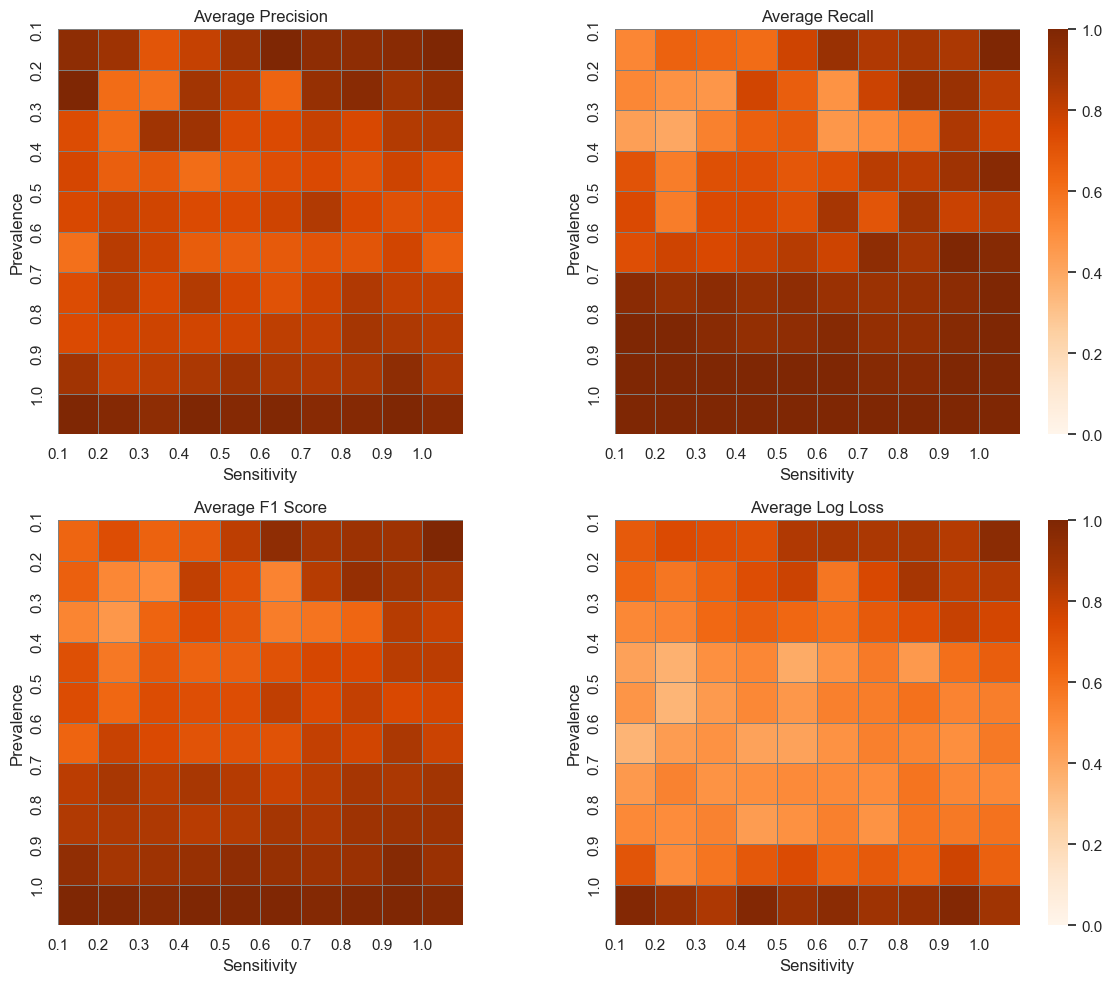

In [40]:
matrices = dict()
titles = dict()
matrices[0, 0] = mean_precision
matrices[0, 1] = mean_recall
matrices[1, 0] = mean_f1
matrices[1, 1] = 1 - mean_loss  # Higher is better
titles[0, 0] = 'Average Precision'
titles[0, 1] = 'Average Recall'
titles[1, 0] = 'Average F1 Score'
titles[1, 1] = 'Average Log Loss'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for row in range(2):
    for col in range(2):
        ax = axes[row, col]
        sns.heatmap(matrices[row, col], 
                    ax=ax, 
                    vmin=0, vmax=1, 
                    square=True,
                    linewidths=0.5, 
                    linecolor='gray', 
                    cbar=(col == 1), 
                    cmap=cmap)
        
        ax.set_title(titles[row, col])
        ax.set_xlabel("Sensitivity")
        ax.set_ylabel("Prevalence")

        ax.set_xticks(range(len(all_sensitivities)))
        ax.set_yticks(range(len(all_prevalences)))
        ax.set_xticklabels([f"{s:.1f}" for s in all_sensitivities])
        ax.set_yticklabels([f"{p:.1f}" for p in all_prevalences])

plt.tight_layout()
plt.savefig("sp3-G.pdf", dpi=300, bbox_inches='tight')

# Sensitivity Analysis

In [24]:
# Sparseness and sensitivities

# Number of diseases
n_disease = 10

# Number of tests: for this experiment need not be the same as n_disease
n_test = 10

n_trials = 10

# Typical number of diagnoses, should be smaller than n_deases/2
expected_number_of_diseases = 3

prev = np.full(n_disease, expected_number_of_diseases/n_disease)*2*np.random.rand(n_disease)

In [25]:
all_delta_posteriors = []
all_specificities = []
all_sensitivities = []
in_degrees_all = []
in_degrees_pos = []

n_positive_connections = []

all_sparsenesses = np.linspace(0.1, 0.9, 10)
sensitivities = np.linspace(0.1, 1, 10)

for i, sparseness in enumerate(all_sparsenesses):
    print(i)
    for j, sensitivity in enumerate(sensitivities):

        connections = np.random.rand(n_test, n_disease) < sparseness 
        sensorig = np.random.beta(a=sensitivity*10+0.1, b=(1-sensitivity)*10+0.1, size=connections.shape)* connections
        specificity = compute_specificity(prev, sensorig, connections)
        
        for n in range(n_trials):
            flag = 1
            while flag:
                state_vector = np.random.random(len(prev)) < prev
                actualdiags = np.nonzero(state_vector)[0].tolist()
                ndiags = len(actualdiags)

                testresults = np.any(np.random.rand(n_test, ndiags) < sensorig[:, actualdiags], axis=1)  # Generate test results

                postest = np.where(testresults == 1)[0]
                negtest = np.where(testresults == 0)[0]
                m = len(postest)

                if m>1:
                    flag = 0  # Exit loop if conditions met
    #                 print(f"trial: {ndiags:3.0f}, {m:3.0f} OK")
            #         else:
            #             print(f"trial: {ndiags:3.0f}, {m:3.0f} try again")

            # Prepare data for Quickscore algorithm
            sens = sensorig[postest, :]                 
            sensneg = sensorig[negtest, :]              
            pfmin = 1 - sens                          
            pfminneg = np.prod(1 - sensneg, axis=0)     

            # Quickscore calculation
            posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg) # comparing all other posteriors with this one

            actualdiseases = np.zeros_like(prev)
            actualdiseases[actualdiags] = 1

            for j, d in enumerate(actualdiags):
                connected= np.where(connections[:,d]==1)[0]
                pos_connected = np.intersect1d(postest, connected)

                n_pos_connected = len(pos_connected)


                for i,f in enumerate(pos_connected):
                    specificity_f = specificity[f,d]
                    sensitivity_f = sensorig[f,d]
                    # Number of connections of finding f to all diseases
                    in_degree_f_all = np.sum(connections[f,:])
                    # Number of connections of finding f to diseases that are present -> will always be 1, 2 or 3
                    in_degree_f_posd = np.sum(connections[f,actualdiags])

                    id_in_pos = np.argmax(postest == f)

                    postest_new= np.delete(postest, id_in_pos)
                    negtest_new = np.append(negtest, f)

                    # Prepare data for Quickscore algorithm
                    sens = sensorig[postest_new, :]                 
                    sensneg = sensorig[negtest_new, :]              
                    pfmin = 1 - sens                          
                    pfminneg = np.prod(1 - sensneg, axis=0)     

                    # Quickscore calculation
                    new_posteriorg, _, _ = fun_quickscoreW2_gmpy2(prev, pfmin, pfminneg)

                    actualdiseases = np.zeros_like(prev)
                    actualdiseases[actualdiags] = 1

                    # Calculate difference in posterior for that disease
                    delta_posterior = posteriorg[d] - new_posteriorg[d]

                    all_delta_posteriors.append(delta_posterior)
                    all_specificities.append(specificity_f)
                    all_sensitivities.append(sensitivity_f)

                    in_degrees_all.append(in_degree_f_all)
                    in_degrees_pos.append(in_degree_f_posd)
                    n_positive_connections.append(n_pos_connected)

0
1
2
3
4
5
6
7
8
9


In [33]:
colors = [
    "#FFA94D",   # orange
    "#ffb482",   
    "#a1c9f4",   
    "#4DA6FF",   # blue
]

cmap = LinearSegmentedColormap.from_list("orange_to_sky", colors)
cmap = cmap.reversed()

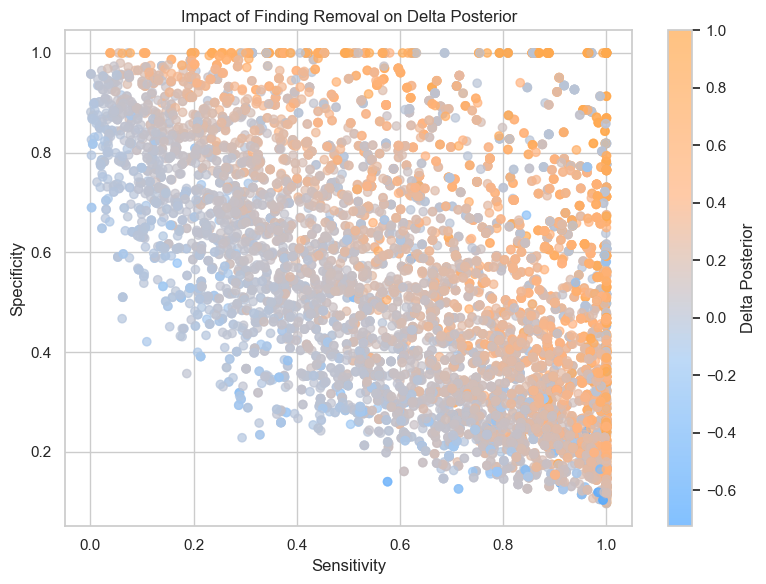

In [34]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(all_sensitivities, all_specificities, c=all_delta_posteriors, alpha=0.7, cmap=cmap)
plt.colorbar(sc, label='Delta Posterior')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.title('Impact of Finding Removal on Delta Posterior')
plt.grid(True)
plt.tight_layout()

plt.savefig("sp3-H.pdf", dpi=300, bbox_inches='tight')